# H1 DC Business Location Analysis
**Charles Riebeling**

## H2 Business Problem:

A client is considering opening a coffeeshop in the Washington, D.C. area. She wants to know which location(s) would be the best options for where to lease a storefront.

## H2 Data Sets and Analyses

I will access Washington D.C. venue data for coffeehouses via the Foursquare API. Specifically, I will create a data set that includes neighborhoods in the DC area which I will retrieve from DC’s open data repository. I will then call the Foursquare API to retrieve the locations of venues similar to the ones the clients want to build in the neighborhoods the clients are interested in. Next, I will append the details of those venues to the data set.

Once the dataset is complete, I will then use kmeans clustering to look at the venues in each neighborhood by the amount of users checking in at those areas.

This will result in being able to make a recommendation for which location the clients should choose for their new coffeehouse.
    

To start, we will import all the packages we will need to access, process, and analyze the data sets we are using.

In [1]:
import pandas as pd
from osgeo import ogr
import geopandas as gpd
import numpy as np
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim

# Fetch file from local path
dc_file = 'C:/Egnyte/Private/criebeling/Data Science/Neighborhood_Clusters/Neighborhood_Clusters.shp'

# Read file into dataframe and plot
neighborhoods = gpd.read_file(dc_file)

neighborhoods.head()

plt = neighborhoods.plot()
neighborhoods.head()

,OBJECTID,WEB_URL,NAME,NBH_NAMES,Shape_Leng,Shape_Area,TYPE,geometry
0,1,http://planning.dc.gov/,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",10711.668010,4.886463e+06,Original,POLYGON ((-76.99401890037231 38.84519662346874...
1,2,http://planning.dc.gov/,Cluster 38,"Douglas, Shipley Terrace",8229.486324,2.367958e+06,Original,POLYGON ((-76.97471813575507 38.85287063601121...
2,3,http://planning.dc.gov/,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",4746.344457,1.119573e+06,Original,"POLYGON ((-76.9687730019474 38.86067206227966,..."
3,4,http://planning.dc.gov/,Cluster 27,"Near Southeast, Navy Yard",7286.968902,1.619167e+06,Original,"POLYGON ((-76.9872595922274 38.87711832849108,..."
4,5,http://planning.dc.gov/,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,Original,POLYGON ((-76.93760147029893 38.88995958845386...


Because the file is a shapefile, we need to fetch the latitude and longitude values of each cluster's center.

In [2]:
#open the shapefile
import sys, os, io
from shapely import wkt
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.Open(dc_file, 0)
layer = ds.GetLayer()

#initialize an empty string
coords = ''

#iterate through the clustes and return the centroid
for feature in layer:
    # get centroid coords in latitude and longitude
    geom = feature.GetGeometryRef()
    wkt = geom.Centroid().ExportToWkt()
    coords = coords + '--' + wkt
    #print(wkt)

coord_list = coords.split('--')

#convert list to dataframe
df = pd.DataFrame(coord_list)

#remove the string elements
df[0]=df[0].str.strip('POINT (')
df[0]=df[0].str.strip(')')

#remove first row and reset index
df = df.iloc[1:]
df.reset_index(drop=True,inplace=True)
df=df[0].str.split(' ', expand=True)

#rename columns
df.columns = ["Longitude", "Latitude"]

,Longitude,Latitude
0,-77.0002623006468,38.8339705957374
1,-76.9799286822983,38.8455588407401
2,-76.9706055997308,38.8556034816972
3,-76.9990008982562,38.8759203796099
4,-76.9513910913679,38.8842162674027


Now that we have the location of the centroid of each neighborhood cluster, we can merge the two dataframes to get a complete data set.

In [3]:
#merge frames
dc_data = pd.concat([neighborhoods, df], 1, ignore_index=True)

#reset headers and add to dc_data
headers = ["ID", "URL", "CLUSTER","NEIGHBORHOODS","SHAPE LENGTH","SHAPE AREA","TYPE", "GEO","LONG","LAT"]

dc_data.columns = headers
dc_data.head()

#change LAT and LONG to floats
dc_data.LAT = dc_data.LAT.astype(float)
dc_data.LONG = dc_data.LONG.astype(float)

,ID,URL,CLUSTER,NEIGHBORHOODS,SHAPE LENGTH,SHAPE AREA,TYPE,GEO,LONG,LAT
0,1,http://planning.dc.gov/,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",10711.668010,4.886463e+06,Original,POLYGON ((-76.99401890037231 38.84519662346874...,-77.000262,38.833971
1,2,http://planning.dc.gov/,Cluster 38,"Douglas, Shipley Terrace",8229.486324,2.367958e+06,Original,POLYGON ((-76.97471813575507 38.85287063601121...,-76.979929,38.845559
2,3,http://planning.dc.gov/,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",4746.344457,1.119573e+06,Original,"POLYGON ((-76.9687730019474 38.86067206227966,...",-76.970606,38.855603
3,4,http://planning.dc.gov/,Cluster 27,"Near Southeast, Navy Yard",7286.968902,1.619167e+06,Original,"POLYGON ((-76.9872595922274 38.87711832849108,...",-76.999001,38.875920
4,5,http://planning.dc.gov/,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,Original,POLYGON ((-76.93760147029893 38.88995958845386...,-76.951391,38.884216


In [4]:
import folium
from geopy.geocoders import Nominatim

# fetch coordinates of DC
address = "Washington, DC"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


# create map using latitude and longitude values
map_dc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dc_data['LAT'], dc_data['LONG'], dc_data['NEIGHBORHOODS']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_dc)  
    
map_dc

Next, we'll access FourSquare to identify the locations of venues similar to the coffeehouse the client would like to open.

In [5]:
# @hidden_cell
#Foursquare creds
CLIENT_ID = '1Y0HFCFABTKZBIUXSSEZG1HMZDBUJG1RBCBU2QZ44CZG5HV2' # Foursquare ID
CLIENT_SECRET = 'G4KU4JTD4CQEQ2KKJ3ZICUZBWBBT12KY1SU31M5KDUQGCXQQ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [6]:
#Get venues from FourSquare
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        #results = dict(results[i:i+2] for i in range(0, len(results), 2))
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGHBORHOODS', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Next, we'll use the function we just defined to get venues in the DC neighborhood clusters.

In [7]:
dc_venues = getNearbyVenues(names=dc_data['NEIGHBORHOODS'],
                                   latitudes=dc_data['LAT'],
                                   longitudes=dc_data['LONG']
                                  )

Now, we'll repeat the shape file conversion process for a DC traffic data set. 

,OBJECTID_1,OBJECTID,SSRSEGID,SOURCESEGI,SOURCEID,QUADCODE,ROADTYPE,STREETID,SEGMENTTYP,FROMNODEID,...,OUTOFSERVI,UPDATETIME,FROMGRADE,TOGRADE,HPMSID,COUNT2015,SOURCE2015,SHAPE_LENG,SHAPELEN,geometry
0,36,434,63,9411,10020680,1,1,100020,2,21699,...,None,2011-03-23T00:00:00.000Z,0,0,XXXXXXX,0.0,None,152.766182,152.766183,"LINESTRING (-77.01287221290001 38.9719995066, ..."
1,37,436,64,12250,10020673,1,1,100020,2,19565,...,None,2011-03-23T00:00:00.000Z,0,0,XXXXXXX,0.0,None,88.610151,88.610135,"LINESTRING (-77.0126308927 38.9712238336, -77...."
2,38,438,65,10726,10020660,1,1,100020,2,20956,...,None,2011-03-23T00:00:00.000Z,0,0,XXXXXXX,0.0,None,132.900424,132.900423,"LINESTRING (-77.01284819270001 38.9699834654, ..."
3,39,440,66,5768,10020630,1,1,100020,2,21986,...,None,2011-03-23T00:00:00.000Z,0,0,XXXXXXX,0.0,None,128.328924,128.328905,"LINESTRING (-77.01364783770001 38.9661418991, ..."
4,40,442,67,9979,10020540,1,1,100020,2,18300,...,None,2011-03-23T00:00:00.000Z,0,0,XXXXXXX,0.0,None,79.356394,79.356426,"LINESTRING (-77.0136212389 38.9555695415, -77...."


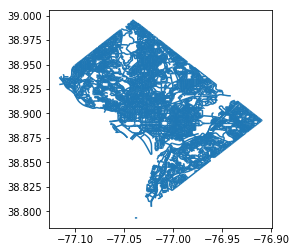

In [8]:
# Fetch file from local path
traffic_file = 'C:/Egnyte/Private/criebeling/Data Science/2015_Traffic_Volume/2015_Traffic_Volume.shp'

# Read file into dataframe and plot
traffic = gpd.read_file(traffic_file)

plt = traffic.plot()
traffic.head()


In [9]:
#open the shapefile
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.Open(dc_file, 0)
layer = ds.GetLayer()

#initialize an empty string
coords = ''

#iterate through the clustes and return the centroid
for feature in layer:
    # get centroid coords in latitude and longitude
    geom = feature.GetGeometryRef()
    wkt = geom.Centroid().ExportToWkt()
    coords = coords + '--' + wkt
    #print(wkt)

coord_list = coords.split('--')

#print(coord_list)

#convert list to dataframe
df = pd.DataFrame(coord_list)
df.head()

#remove the string elements
df[0]=df[0].str.strip('POINT (')
df[0]=df[0].str.strip(')')

#remove first row and reset index
df = df.iloc[1:]
df.reset_index(drop=True,inplace=True)
df=df[0].str.split(' ', expand=True)

#rename columns
df.columns = ["Longitude", "Latitude"]

df.head()

,Longitude,Latitude
0,-77.0002623006468,38.8339705957374
1,-76.9799286822983,38.8455588407401
2,-76.9706055997308,38.8556034816972
3,-76.9990008982562,38.8759203796099
4,-76.9513910913679,38.8842162674027


In [10]:
#merge frames
traffic_data = pd.concat([traffic, df], 1, ignore_index=True)
traffic_data = traffic_data.iloc[:,30:37]

#reset headers and add to dc_data
headers = ["COUNT", "SOURCE", "SHAPE","SHAPE_LEN","GEOMETRY","LONG","LAT"]

traffic_data.columns = headers

#change LAT and LONG to floats
traffic_data.LAT = traffic_data.LAT.astype(float)
traffic_data.LONG = traffic_data.LONG.astype(float)

,COUNT,SOURCE,SHAPE,SHAPE_LEN,GEOMETRY,LONG,LAT
0,0.0,None,152.766182,152.766183,"LINESTRING (-77.01287221290001 38.9719995066, ...",-77.000262,38.833971
1,0.0,None,88.610151,88.610135,"LINESTRING (-77.0126308927 38.9712238336, -77....",-76.979929,38.845559
2,0.0,None,132.900424,132.900423,"LINESTRING (-77.01284819270001 38.9699834654, ...",-76.970606,38.855603
3,0.0,None,128.328924,128.328905,"LINESTRING (-77.01364783770001 38.9661418991, ...",-76.999001,38.875920
4,0.0,None,79.356394,79.356426,"LINESTRING (-77.0136212389 38.9555695415, -77....",-76.951391,38.884216


check_ins = getCheckinbyVenues(dc_venues['Venue ID'])
check_ins.head()

In [11]:
#limit to just coffee shops and cafes
dc_venues = dc_venues[dc_venues['Venue Category'].isin(['Coffee Shop','Café'])]

dc_venues.groupby('NEIGHBORHOODS').sum()

dc_venues.head()

# one hot encoding
dc_onehot = pd.get_dummies(dc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dc_onehot['NEIGHBORHOODS'] = dc_venues['NEIGHBORHOODS'] 

# move neighborhood column to the first column
fixed_columns = [dc_onehot.columns[-1]] + list(dc_onehot.columns[:-1])
dc_onehot = dc_onehot[fixed_columns]

dc_onehot.head()

dc_grouped = dc_onehot.groupby('NEIGHBORHOODS').sum().reset_index()
dc_grouped

dc_grouped.loc[:,'TOTAL'] = dc_grouped.sum(axis=1)

dc_grouped.head()

,NEIGHBORHOODS,Café,Coffee Shop,TOTAL
0,"Arboretum, Anacostia River",2,4,6
1,"Brightwood Park, Crestwood, Petworth",2,7,9
2,"Brookland, Brentwood, Langdon",1,7,8
3,"Capitol Hill, Lincoln Park",1,4,5
4,"Capitol View, Marshall Heights, Benning Heights",1,5,6


Now, we'll merge the dc_grouped data with the traffic data we pulled. This will give us a complete data set with the count of coffee shops for each neighborhood cluster as well as the traffic within the clusters.

In [12]:
first_df = pd.merge(dc_data,dc_grouped, on='NEIGHBORHOODS')
first_df.head()

final_df = pd.merge(first_df,traffic_data, on="LAT")

final_df = pd.DataFrame(final_df)
final_df.head()

final_df = final_df.drop(['GEO'], axis=1)
final_df = final_df.drop(['GEOMETRY'], axis=1)
final_df = final_df.drop(['SHAPE LENGTH'], axis=1)
final_df = final_df.drop(['SHAPE AREA'], axis=1)
final_df = final_df.drop(['TYPE'], axis=1)
final_df = final_df.drop(['Café'], axis=1)
final_df = final_df.drop(['Coffee Shop'], axis=1)
final_df = final_df.drop(['SOURCE'], axis=1)
final_df = final_df.drop(['SHAPE'], axis=1)
final_df = final_df.drop(['SHAPE_LEN'], axis=1)
final_df = final_df.drop(['LONG_y'], axis=1)
final_df = final_df.drop(['CLUSTER'], axis=1)
final_df = final_df.drop(['URL'], axis=1)
final_df.head()


,ID,NEIGHBORHOODS,LONG_x,LAT,TOTAL,COUNT
0,1,"Congress Heights, Bellevue, Washington Highlands",-77.000262,38.833971,3,0.0
1,2,"Douglas, Shipley Terrace",-76.979929,38.845559,5,0.0
2,3,"Woodland/Fort Stanton, Garfield Heights, Knox ...",-76.970606,38.855603,4,0.0
3,4,"Near Southeast, Navy Yard",-76.999001,38.875920,6,0.0
4,5,"River Terrace, Benning, Greenway, Dupont Park",-76.951391,38.884216,5,0.0


Below, we'll run our clustering algorithm.

In [13]:
# set number of clusters
kclusters = 5

final_df_clustering = final_df.drop('NEIGHBORHOODS', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
final_df.insert(0, 'Cluster Labels', kmeans.labels_)

dc_merged = dc_data

# merge dc_grouped with dc_data to add latitude/longitude for each neighborhood
dc_merged = dc_merged.merge(final_df, on='NEIGHBORHOODS')

dc_merged.head()

dc_merged.groupby('Cluster Labels').mean()
dc_merged.describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,46.000000,46.000000,4.600000e+01,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,23.500000,10457.257487,3.857591e+06,-77.010671,38.907382,1.739130,23.500000,-77.010671,38.907382,6.347826,0.951390
std,13.422618,8391.641042,3.215577e+06,0.042207,0.038549,1.219012,13.422618,0.042207,0.038549,1.791553,3.199482
min,1.000000,1990.057774,3.120618e+05,-77.097163,38.833915,0.000000,1.000000,-77.097163,38.833915,2.000000,0.000000
25%,12.250000,6919.762564,1.943120e+06,-77.040342,38.879436,1.000000,12.250000,-77.040342,38.879436,5.000000,0.000000
50%,23.500000,8882.829263,3.433941e+06,-77.011067,38.909118,2.000000,23.500000,-77.011067,38.909118,6.500000,0.000000
75%,34.750000,10654.003877,4.497491e+06,-76.982532,38.929527,3.000000,34.750000,-76.982532,38.929527,8.000000,0.000000
max,46.000000,57862.299890,2.117557e+07,-76.926930,38.985778,4.000000,46.000000,-76.926930,38.985778,10.000000,14.346000


In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dc_merged['LAT_y'], dc_merged['LONG_x'], dc_merged['NEIGHBORHOODS'], dc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Let's look at these clusters in more detail.

In [15]:
dc_merged.loc[dc_merged['Cluster Labels'] == 0].describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,8.00000,8.000000,8.000000e+00,8.000000,8.000000,8.0,8.00000,8.000000,8.000000,8.00000,8.0
mean,42.50000,17855.100417,6.066794e+06,-77.019709,38.898071,0.0,42.50000,-77.019709,38.898071,5.87500,0.0
std,2.44949,18536.952259,6.750538e+06,0.031610,0.050841,0.0,2.44949,0.031610,0.050841,1.95941,0.0
min,39.00000,1990.057774,3.120618e+05,-77.066917,38.833915,0.0,39.00000,-77.066917,38.833915,2.00000,0.0
25%,40.75000,5118.677022,1.286708e+06,-77.040432,38.860524,0.0,40.75000,-77.040432,38.860524,5.00000,0.0
50%,42.50000,13453.707531,5.267406e+06,-77.023423,38.889361,0.0,42.50000,-77.023423,38.889361,6.00000,0.0
75%,44.25000,21330.107927,6.913531e+06,-76.993579,38.931305,0.0,44.25000,-76.993579,38.931305,7.25000,0.0
max,46.00000,57862.299890,2.117557e+07,-76.975153,38.974975,0.0,46.00000,-76.975153,38.974975,8.00000,0.0


In [16]:
dc_merged.loc[dc_merged['Cluster Labels'] == 1].describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,13.00000,13.000000,1.300000e+01,13.000000,13.000000,13.0,13.00000,13.000000,13.000000,13.000000,13.0
mean,7.00000,7746.145431,2.645362e+06,-76.989794,38.887263,1.0,7.00000,-76.989794,38.887263,5.769231,0.0
std,3.89444,2129.175855,1.197010e+06,0.042633,0.026457,0.0,3.89444,0.042633,0.026457,1.690850,0.0
min,1.00000,4746.344457,1.119573e+06,-77.067301,38.833971,1.0,1.00000,-77.067301,38.833971,3.000000,0.0
25%,4.00000,5884.746359,1.596970e+06,-77.021004,38.875920,1.0,4.00000,-77.021004,38.875920,5.000000,0.0
50%,7.00000,7599.065608,2.524927e+06,-76.983572,38.899814,1.0,7.00000,-76.983572,38.899814,5.000000,0.0
75%,10.00000,8570.352866,3.381462e+06,-76.951391,38.908162,1.0,10.00000,-76.951391,38.908162,7.000000,0.0
max,13.00000,11251.012821,4.886463e+06,-76.926930,38.910747,1.0,13.00000,-76.926930,38.910747,8.000000,0.0


In [17]:
dc_merged.loc[dc_merged['Cluster Labels'] == 2].describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,12.00000,12.000000,1.200000e+01,12.000000,12.000000,12.0,12.00000,12.000000,12.000000,12.000000,12.0
mean,21.00000,9559.936951,3.827149e+06,-77.026433,38.932458,2.0,21.00000,-77.026433,38.932458,6.583333,0.0
std,4.06761,2936.095754,1.969122e+06,0.046234,0.039072,0.0,4.06761,0.046234,0.039072,1.831955,0.0
min,15.00000,5447.120059,1.339009e+06,-77.097163,38.863112,2.0,15.00000,-77.097163,38.863112,4.000000,0.0
25%,17.75000,7297.216593,2.974938e+06,-77.061914,38.910778,2.0,17.75000,-77.061914,38.910778,5.750000,0.0
50%,21.00000,9455.149582,3.561363e+06,-77.021942,38.945745,2.0,21.00000,-77.021942,38.945745,6.500000,0.0
75%,24.25000,10255.971516,4.261582e+06,-77.001176,38.957918,2.0,24.25000,-77.001176,38.957918,7.250000,0.0
max,27.00000,15858.747211,9.082501e+06,-76.932321,38.985778,2.0,27.00000,-76.932321,38.985778,10.000000,0.0


In [18]:
dc_merged.loc[dc_merged['Cluster Labels'] == 3].describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.0
mean,34.000000,9995.491023,3.984098e+06,-77.013935,38.917155,3.0,34.000000,-77.013935,38.917155,7.333333,0.0
std,2.738613,1985.975549,1.207267e+06,0.042352,0.019831,0.0,2.738613,0.042352,0.019831,1.414214,0.0
min,30.000000,6217.668679,1.894376e+06,-77.077847,38.871439,3.0,30.000000,-77.077847,38.871439,5.000000,0.0
25%,32.000000,9153.209237,3.400110e+06,-77.046517,38.919423,3.0,32.000000,-77.046517,38.919423,7.000000,0.0
50%,34.000000,10359.348735,3.983623e+06,-77.006447,38.926230,3.0,34.000000,-77.006447,38.926230,8.000000,0.0
75%,36.000000,10481.011478,4.813915e+06,-76.982185,38.929003,3.0,36.000000,-76.982185,38.929003,8.000000,0.0
max,38.000000,13288.233442,6.030978e+06,-76.962278,38.929912,3.0,38.000000,-76.962278,38.929912,9.000000,0.0


In [19]:
dc_merged.loc[dc_merged['Cluster Labels'] == 4].describe()

,ID_x,SHAPE LENGTH,SHAPE AREA,LONG,LAT_x,Cluster Labels,ID_y,LONG_x,LAT_y,TOTAL,COUNT
count,4.00000,4.000000,4.000000e+00,4.000000,4.000000,4.0,4.00000,4.000000,4.000000,4.000000,4.000000
mean,23.00000,8203.621958,3.185617e+06,-77.005818,38.894175,4.0,23.00000,-77.005818,38.894175,6.250000,10.940990
std,6.97615,2415.215703,2.213114e+06,0.036539,0.042352,0.0,6.97615,0.036539,0.042352,2.217356,2.796811
min,14.00000,6606.101905,1.906664e+06,-77.040987,38.859838,4.0,14.00000,-77.040987,38.859838,4.000000,7.758570
25%,19.25000,6780.253253,2.016030e+06,-77.032172,38.860437,4.0,19.25000,-77.032172,38.860437,4.750000,9.366435
50%,24.50000,7219.173546,2.169408e+06,-77.010817,38.884539,4.0,24.50000,-77.010817,38.884539,6.000000,10.829695
75%,28.25000,8642.542251,3.338995e+06,-76.984463,38.918276,4.0,28.25000,-76.984463,38.918276,7.500000,12.404250
max,29.00000,11770.038834,6.496990e+06,-76.960650,38.947782,4.0,29.00000,-76.960650,38.947782,9.000000,14.346000


Based on the clustering algorithm, cluster 4 (in orange on the map) is the group of neighborhoods that sees the most traffic and has the most coffeeshops, and, therefore, is where the client should consider purchasing a storefront.